In [127]:
## Set up dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

df = pd.read_csv("../data/youtube_project_database.csv")

In [128]:
## Clean up data

import re

#Views
df = df[df['viewCount'].notna()]
df['logViews'] = np.log(df['viewCount'] + 1)

mean_log_views = np.mean(df['logViews'])
std_log_views = np.std(df['logViews'])
df['zLogViews'] = (df['logViews'] - mean_log_views) / std_log_views

df = df[np.abs(df['zLogViews']) < 2]

# Categories
df["categoryId"].astype("category")

# Average Views
df = df[df["videoCount"] > 0]
df['avgViewsPerVid'] = pd.to_numeric(df['avgViewsPerVid'])

# Titles
def process_title(title):
    title = str(title)
    # title = re.sub(r"&.*?;", " ", title)
    title = re.sub(r"[!\"#\＄%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]", " ", title)
    title = title.lower()
    title = title.split(" ")
    title = list(filter(None, title))
    return title

titles = df["vidTitle"].map(process_title)

# Tags
def process_tags(tags):
    if(tags == None):
        return []
    tags = str(tags)
    tags = tags.lower()
    tags = tags[1:-1]
    tags = tags.split(", ")
    tags = [tag[1:-1] for tag in tags]
    tags = list(filter(None, tags))
    return tags

tags = df["tags"].map(process_tags)
df["tagCount"] = len(tags)

# Times
df.loc[df['retrievalTime'].isna(), 'retrievalTime'] = '2023-04-07 14:25:00'

df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')
df['retrievalTime'] = pd.to_datetime(df['retrievalTime'], format='%Y-%m-%d %H:%M:%S')
df['timeElapsed'] = (df['retrievalTime'] - df['publishedAt']).dt.days + (df['retrievalTime'] - df['publishedAt']).dt.seconds/(24 * 60 * 60)

In [129]:
## Train Model for FastText

from gensim.models import Word2Vec, FastText

def convertToVec(ft, wordlist):
    if (len(wordlist) == 0):
        return np.zeros(ft.vector_size)
    else:
        return np.mean([ft.wv[word] for word in wordlist], axis=0)

vector_size_titles = 300
ft_titles = FastText(titles, vector_size=vector_size_titles)
title_vectors = [convertToVec(ft_titles, title) for title in titles]
title_vec_cols = ["titleVec" + str(num) for num in range(vector_size_titles)]
title_vec_df = pd.DataFrame(title_vectors, index=df.index, columns = title_vec_cols)
df = pd.concat([df, title_vec_df], axis=1)
ft_titles.save("ft_titles.bin")

vector_size_tags = 300
ft_tags = FastText(tags, min_count=2, vector_size = vector_size_tags)
tags_vectors = [convertToVec(ft_tags, tagList) for tagList in tags]
tags_vec_cols = ["tagsVec" + str(num) for num in range(vector_size_tags)]
tags_vec_df = pd.DataFrame(tags_vectors, index=df.index, columns = tags_vec_cols)
df = pd.concat([df, tags_vec_df], axis=1)
ft_tags.save("ft_tags.bin")

In [130]:
## Train Model for Img2Vec

from img2vec_pytorch import Img2Vec
from PIL import Image
import requests
from io import BytesIO

# Initialize Img2Vec with GPU
img2vec = Img2Vec()

# Read in an image (rgb format)
thumbnail_vectors = df['thumbnail lq'].map(lambda url : img2vec.get_vec(Image.open(BytesIO(requests.get(url).content)))).tolist()

vector_size_thumbnail = len(thumbnail_vectors[0])
thumbnail_vec_cols = ["thumbnailVec" + str(num) for num in range(vector_size_thumbnail)]
thumbnail_vec_df = pd.DataFrame(thumbnail_vectors, index=df.index, columns = thumbnail_vec_cols)
df = pd.concat([df, thumbnail_vec_df], axis=1)

C:\Users\me123\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\me123\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

x_labels = ["categoryId", "tagCount", "avgViewsPerVid", "subscriberCount", "videoCount", "timeElapsed"] + title_vec_cols + tags_vec_cols + thumbnail_vec_cols
y_labels = ["zLogViews"]
x = df.loc[:, x_labels]
y = df.loc[:, y_labels]
# dmatrix = xgb.DMatrix(data=x,label=y, enable_categorical=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror',
                           learning_rate = 0.1,
                           max_depth = 5,
                           n_estimators = 300)

xgb_reg.fit(x_train, y_train)
pred = xgb_reg.predict(x_test)

xgb_reg.save_model('xgb.json')

print("MAE (just mean): " + str(mean_absolute_error(np.exp(y_test), x_test["avgViewsPerVid"])))
print("MAE (all params): " + str(mean_absolute_error(np.exp(y_test * std_log_views + mean_log_views), np.exp(pred * std_log_views + mean_log_views))))

KeyError: "None of [Index(['zLogViews'], dtype='object')] are in the [columns]"

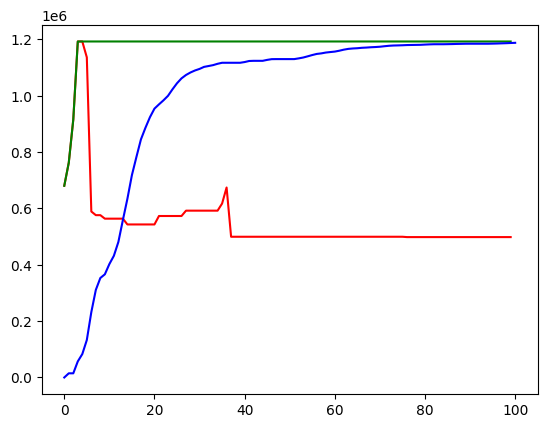

In [126]:
import numpy as np
import numpy.random as random
import xgboost as xgb
import pandas as pd

time = 100

xgb_reg = xgb.Booster()
xgb_reg.load_model("xgb.json")

def process_title(title):
    title = str(title)
    # title = re.sub(r"&.*?;", " ", title)
    title = re.sub(r"[!\"#\＄%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]", " ", title)
    title = title.lower()
    title = title.split(" ")
    title = list(filter(None, title))
    return title

def process_tags(tags):
    if(tags == None or tags == ""):
        return []
    tags = str(tags)
    tags = tags.lower()
    tags = re.sub(r"[!\"#\＄%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]", " ", tags)
    tags = tags.split(",")
    tags = [tag.strip() for tag in tags]
    tags = list(filter(None, tags))
    return tags

def convertToVec(ft, wordlist):
    if (len(wordlist) == 0):
        return np.zeros(ft.vector_size)
    else:
        return np.mean([ft.wv[word] for word in wordlist], axis=0)

df = pd.DataFrame()
df['timeElapsed'] = range(1,time+1)
df = pd.concat([df, pd.DataFrame( np.repeat(2, time, axis=0) , columns=["categoryId"])]     , axis=1)
df = pd.concat([df, pd.DataFrame( np.repeat(100000 + random.rand() * 1000000, time, axis=0) , columns=["avgViewsPerVid"])] , axis=1)
df = pd.concat([df, pd.DataFrame( np.repeat(100 + random.rand() * 1000000, time, axis=0) , columns=["subscriberCount"])], axis=1)
df = pd.concat([df, pd.DataFrame( np.repeat(100, time, axis=0) , columns=["videoCount"])]     , axis=1)
df['categoryId'].astype("category")

title_vectors = convertToVec(ft_titles, process_title('A day in the life of a big pig'))
title_vec_cols = ["titleVec" + str(num) for num in range(300)]
df = pd.concat([df, pd.DataFrame( np.repeat([np.zeros(300)], time, axis=0), columns=title_vec_cols)], axis=1)

tags_vectors = convertToVec(ft_tags, process_tags('shorts, wow, much'))
tags_vec_cols = ["tagsVec" + str(num) for num in range(300)]
df = pd.concat([df, pd.DataFrame( np.repeat([np.zeros(300)], time, axis=0), columns=tags_vec_cols)], axis=1)
df = pd.concat([df, pd.DataFrame( np.repeat(10, time, axis=0) , columns=["tagCount"])]     , axis=1)

img = Image.open("loz__spirit_tracks___the_sacred_duet_by_csgamegalaxy_dc9xy23-fullview.jpg")
thumbnail_vectors = img2vec.get_vec([img])
vector_size_thumbnail = len(thumbnail_vectors[0])
thumbnail_vec_cols = ["thumbnailVec" + str(num) for num in range(vector_size_thumbnail)]
df = pd.concat([df, pd.DataFrame( np.repeat(thumbnail_vectors, time, axis=0), columns=thumbnail_vec_cols)], axis=1)

x_labels = ["categoryId", "tagCount", "avgViewsPerVid", "subscriberCount", "videoCount", "timeElapsed"] + title_vec_cols + tags_vec_cols + thumbnail_vec_cols
x = df.loc[:, x_labels]

dmatrix = xgb.DMatrix(data=x, enable_categorical=True)
pred = np.exp(xgb_reg.predict(dmatrix) * std_log_views + mean_log_views)
max_pred = np.maximum.accumulate(pred)
smooth_pred = np.array([0])
lerp_factor = 0
lerp_rand_step = 0.1;
random.seed(int(pred[1]))
for num in max_pred:
    lerp_factor = max(0, lerp_factor + (random.rand()-0.5) * lerp_rand_step)
    smooth_pred = np.append(smooth_pred, smooth_pred[-1] * (1-lerp_factor) + num * lerp_factor)
plt.plot(pred, c="red")
plt.plot(max_pred, c="green")
plt.plot(smooth_pred, c="blue")